# 1. Import Install dependencies



In [ ]:
%pip install tensorflow
%pip install tensorflow-io
%pip install tensorflow-gpu
%pip install pystan
%pip install fbprophet

In [ ]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

# Dependencies
import os 
import math
import numpy as np 
import pandas as pd 
from fbprophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import date, datetime
import time

# Building model
import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MAE, MSE, MAPE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, sigmoid, softmax, tanh
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler

In [ ]:
# Connect to Google drive 
from google.colab import drive
drive_path = os.path.join('/','content', 'drive')
folder_path = os.path.join(drive_path, 'MyDrive','Colab Notebooks')
data_path = os.path.join(drive_path , folder_path,'data','bitcoin' ,'btc.csv')
model_path = os.path.join( drive_path , folder_path,'models','BitCoinModel')

# Connect to drive 
drive.mount(drive_path)
print("drive path :\t "+drive_path)
print("folder path :\t "+folder_path)
print("data : \t\t "+data_path) 
print("model path :\t "+model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive path :	 /content/drive
folder path :	 /content/drive/MyDrive/Colab Notebooks
data : 		 /content/drive/MyDrive/Colab Notebooks/data/bitcoin/btc.csv
model path :	 /content/drive/MyDrive/Colab Notebooks/models/BitCoinModel


# 2. Data Exploration

In [ ]:
df = pd.read_csv(data_path)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


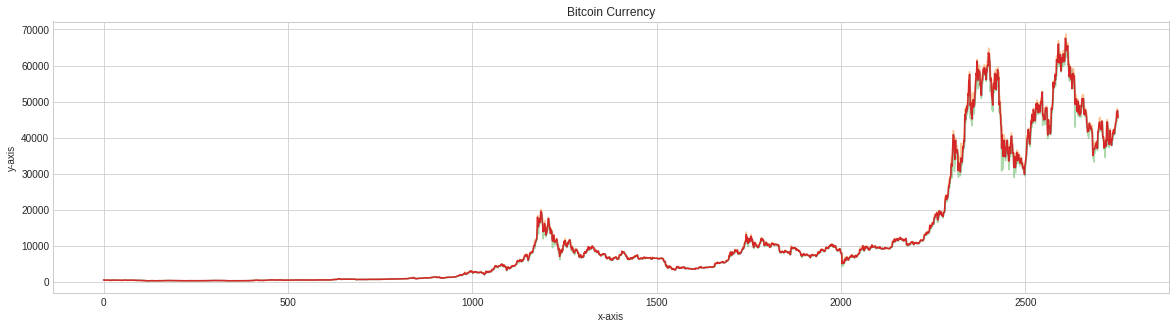

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(df['Open'], alpha=0.4)
ax.plot(df['High'], alpha=0.4)
ax.plot(df['Low'], alpha=0.4)
ax.plot(df['Close'])
ax.set(title='Bitcoin Currency', xlabel='x-axis', ylabel='y-axis');

Text(0.5, 1.0, 'Volume in Bitcoin Currency')

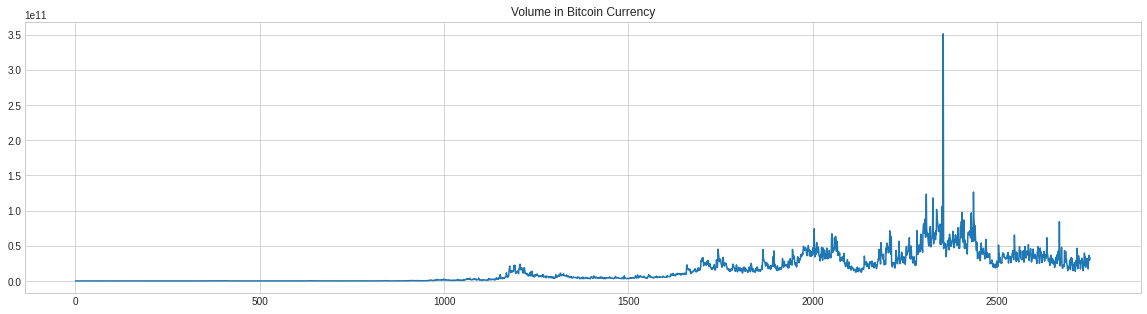

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df['Volume']);
ax.set_title("Volume in Bitcoin Currency")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2753 entries, 0 to 2752
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2753 non-null   object 
 1   Open       2753 non-null   float64
 2   High       2753 non-null   float64
 3   Low        2753 non-null   float64
 4   Close      2753 non-null   float64
 5   Adj Close  2753 non-null   float64
 6   Volume     2753 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 150.7+ KB


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2753.000000,2753.000000,2753.000000,2753.000000,2753.000000,2.753000e+03
mean,11743.896611,12057.667933,11400.632065,11758.581095,11758.581095,1.487851e+10
std,16385.417523,16821.512147,15889.766805,16392.681953,16392.681953,1.993986e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,609.684021,612.054016,606.924988,609.734985,609.734985,8.167310e+07
50%,6379.666992,6504.515137,6294.569824,6385.620117,6385.620117,5.244857e+09
75%,10777.529297,11039.099609,10472.356445,10779.900391,10779.900391,2.506455e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


# 3. Data Feature Engineering

In [ ]:
# Convert date into numbers
# df['Year'] = df['Date'].apply(lambda x: int(str(x).split('-')[0]))
# df['Month'] = df['Date'].apply(lambda x: int(str(x).split('-')[1]))
# df['Day'] = df['Date'].apply(lambda x: int(str(x).split('-')[2]))


# Convert date to timestamp
# df['Date'] = df['Date'].apply(lambda x: time.mktime(datetime.strptime(x+" 22:24:46", '%Y-%m-%d %H:%M:%S').timetuple() ))
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
# Remove Adj Close
df = df.drop('Adj Close', axis=1)

In [ ]:
# Removing Outliers from the data
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.10)
    Q3 = df.quantile(0.90)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList


# Index List of Non-Outliers
nonOutlierList = Remove_Outlier_Indices(df[['Open','High','Low', 'Close','Volume']])

# Non-Outlier Subset of the Given Dataset
dfSubset = df[nonOutlierList]
dfSubset['Date'] = df['Date']
dfSubset.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    5
dtype: int64

In [ ]:
# Removing Null values
dfSubset = dfSubset.dropna()

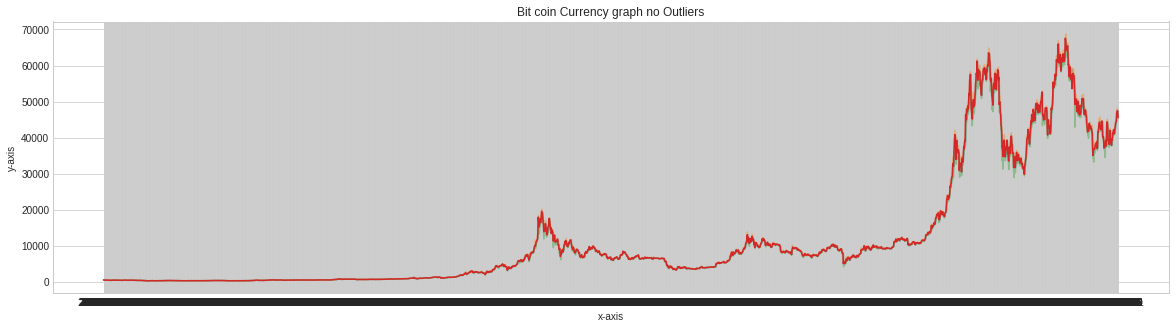

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))

date = dfSubset['Date']
ax.plot(date ,dfSubset['Open'], alpha=0.4)
ax.plot(date ,dfSubset['High'], alpha=0.4)
ax.plot(date ,dfSubset['Low'], alpha=0.4)
ax.plot(date ,dfSubset['Close'])

ax.set(title='Bit coin Currency graph no Outliers', xlabel='x-axis', ylabel='y-axis');

Text(0.5, 1.0, 'Volume in Bitcoin Currency No Outliers')

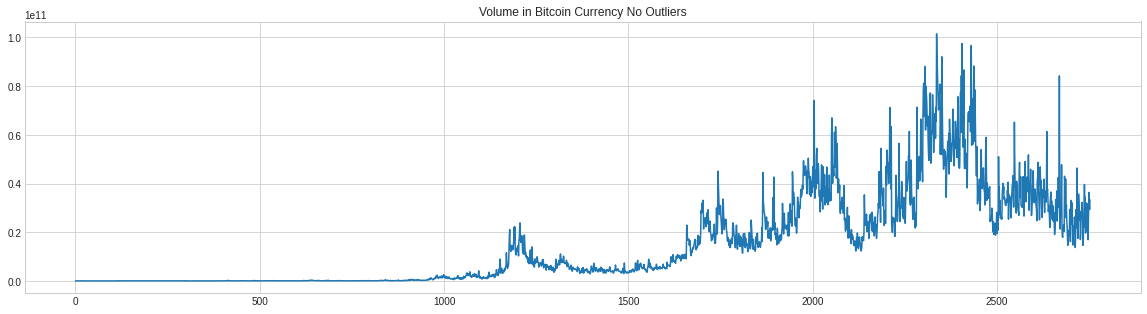

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(dfSubset['Volume']);
ax.set_title("Volume in Bitcoin Currency No Outliers")

In [ ]:
# Expanding window statistics
future_forecast = 80

window = dfSubset.expanding() 
df_feat = dfSubset.copy()


WINDOWS = 7
def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

    
# Rolling window 
df_feat['mov.Avg Open'] =   moving_average(dfSubset['Open'], WINDOWS)
df_feat['mov.Avg High'] = moving_average(dfSubset['High'], WINDOWS)
df_feat['mov.Avg Low'] = moving_average(dfSubset['Low'], WINDOWS)
df_feat['mov.Avg Close'] = moving_average(dfSubset['Close'], WINDOWS)
df_feat['mov.Avg Volume'] = moving_average(dfSubset['Volume'], WINDOWS)

df_feat.head()

,Date,Open,High,Low,Close,Volume,mov.Avg Open,mov.Avg High,mov.Avg Low,mov.Avg Close,mov.Avg Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,421.539573,433.866281,403.778429,417.462572,3.230436e+07
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,417.237714,429.285993,399.308428,412.586997,3.367163e+07
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,412.422860,424.523137,398.788997,410.748997,3.257609e+07
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,410.612287,422.680708,400.999996,412.124568,3.022481e+07
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,411.881287,420.298850,402.069855,410.783997,2.710563e+07


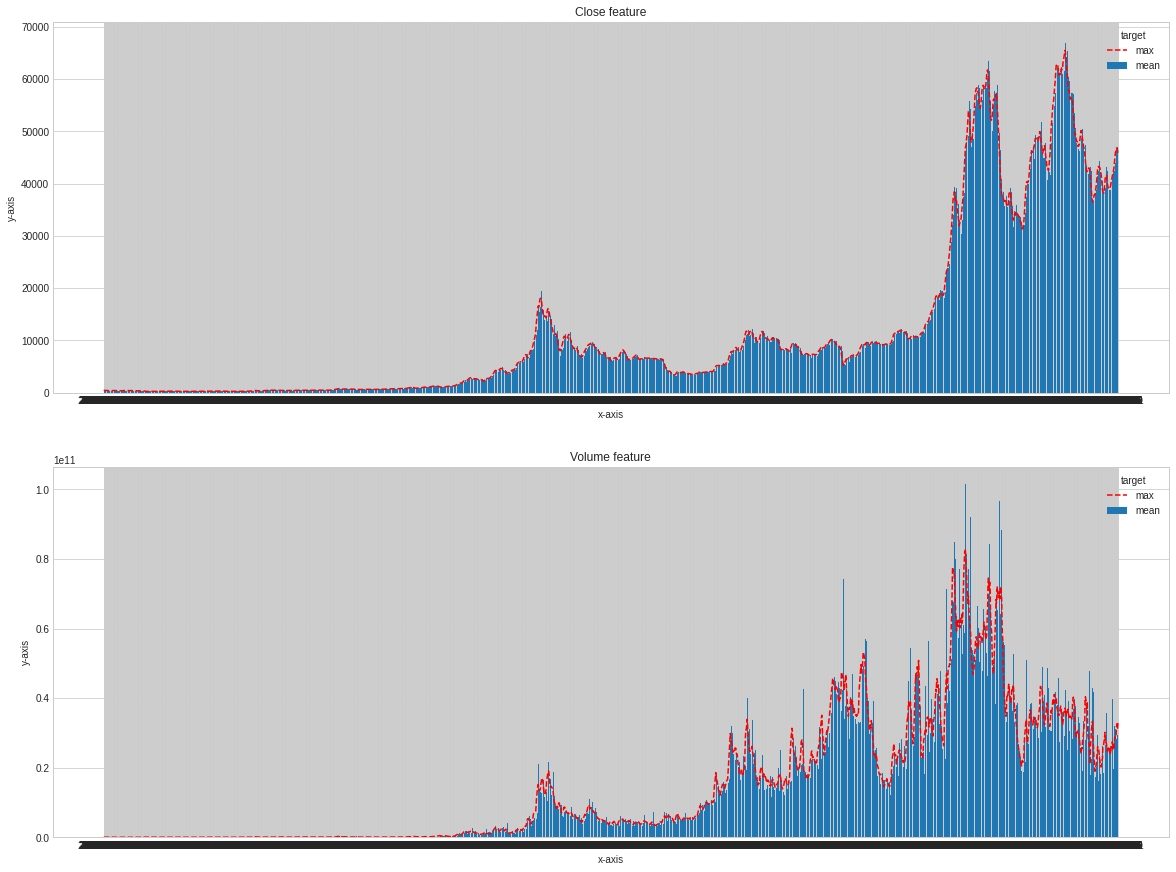

In [ ]:
# Customizing the Y and X axis  
plt.style.use('seaborn-whitegrid')
fig, (ax0, ax1) = plt.subplots( nrows=2, ncols=1, figsize=(20,15) )


ax0.bar(df_feat['Date'],df_feat['Close'])
ax0.plot(df_feat['Date'],df_feat['mov.Avg Close'], linestyle='--', color='red')
ax0.set(title='Close feature', xlabel='x-axis', ylabel='y-axis');
ax0.legend(['max', 'mean', 'Moving Average','Target'], title='target')


ax1.bar(df_feat['Date'],df_feat['Volume'], alpha=1,)
ax1.plot(df_feat['Date'],df_feat['mov.Avg Volume'], linestyle='--', color='red')
ax1.set(title='Volume feature', xlabel='x-axis', ylabel='y-axis');
ax1.legend(['max', 'mean', 'Moving Average','Target'], title='target')

# 4. Data Pre processing

In [ ]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 2752
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2748 non-null   object 
 1   Open            2748 non-null   float64
 2   High            2748 non-null   float64
 3   Low             2748 non-null   float64
 4   Close           2748 non-null   float64
 5   Volume          2748 non-null   float64
 6   mov.Avg Open    2748 non-null   float64
 7   mov.Avg High    2748 non-null   float64
 8   mov.Avg Low     2748 non-null   float64
 9   mov.Avg Close   2748 non-null   float64
 10  mov.Avg Volume  2748 non-null   float64
dtypes: float64(10), object(1)
memory usage: 257.6+ KB


In [ ]:
df_feat.head()

,Date,Open,High,Low,Close,Volume,mov.Avg Open,mov.Avg High,mov.Avg Low,mov.Avg Close,mov.Avg Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,421.539573,433.866281,403.778429,417.462572,3.230436e+07
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,417.237714,429.285993,399.308428,412.586997,3.367163e+07
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,412.422860,424.523137,398.788997,410.748997,3.257609e+07
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,410.612287,422.680708,400.999996,412.124568,3.022481e+07
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,411.881287,420.298850,402.069855,410.783997,2.710563e+07


In [ ]:
# Select features (columns) to be involved intro training and predictions


predict_value = 'Close'      # Legend that we want to predict 

# Legends that support the legend we want to predict
cols = [
     'Open', 'High', 'Low', 'Volume', 'mov.Avg Open', 'mov.Avg High' ,'mov.Avg Volume','mov.Avg Close'
]

n_future = future_forecast        # Number of days we want top predict into the future
n_past =  40                      # Number of past days we want to use to predict the future
n_starting_date = df_feat['Date'][0]

# Generate columns 
cols.insert(0, predict_value)  

# Extract dates (will be used in visualization)
datelist_train = list(df_feat['Date'])
datelist_train = [datetime.strptime(date,'%Y-%m-%d').date() for date in datelist_train]


dates = df_feat['Date']
future_forcast = np.array([i for i in range(len(dates)+n_future )]).reshape(-1, 1)
adjusted_dates = future_forcast[:-n_future ]
print('Training set shape == {}'.format(df_feat.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (2748, 11)
All timestamps == 2748
Featured selected: ['Close', 'Open', 'High', 'Low', 'Volume', 'mov.Avg Open', 'mov.Avg High', 'mov.Avg Volume', 'mov.Avg Close']


In [ ]:
dataset_train =  df_feat[cols].astype(str)
dataset_train = dataset_train.astype(float)


# Using multiple features (predictors)
training_set = dataset_train.to_numpy()
print('Shape of training set == {}.'.format(training_set.shape))


Shape of training set == (2748, 9).


In [ ]:

# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1]).shape

(2748, 1)

In [ ]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (2629, 40, 8).
y_train shape == (2629, 1).


# 5. Creating LSTM Model

In [ ]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(128,activation="sigmoid",input_shape=(n_past, dataset_train.shape[1]-1)) )

# Adding Dropout layer
model.add(Dropout(0.2))

 # Output layer
model.add(Dense(1))

# Compiling the Neural Network
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128)               70144     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 70,273
Trainable params: 70,273
Non-trainable params: 0
_________________________________________________________________


# 6. Training and Validating the Model

In [ ]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
# mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
# tb = TensorBoard('logs')

callbacks = [
    es,               
    rlr, 
    # mcp, 
    # tb
]
history = model.fit(X_train, y_train, shuffle=True, epochs=150, callbacks=callbacks, validation_split=0.2, verbose=1, batch_size=256)


9/9 [==============================] - 2s 183ms/step - loss: 0.0427 - val_loss: 1.4585 - lr: 0.0010
Epoch 18/150
9/9 [==============================] - 2s 183ms/step - loss: 0.0445 - val_loss: 1.4768 - lr: 0.0010
Epoch 19/150
9/9 [==============================] - 2s 180ms/step - loss: 0.0427 - val_loss: 1.4468 - lr: 0.0010
Epoch 20/150
9/9 [==============================] - 2s 185ms/step - loss: 0.0397 - val_loss: 1.3891 - lr: 0.0010
Epoch 21/150
9/9 [==============================] - 2s 182ms/step - loss: 0.0392 - val_loss: 1.4016 - lr: 0.0010
Epoch 22/150
9/9 [==============================] - 2s 182ms/step - loss: 0.0382 - val_loss: 1.3528 - lr: 0.0010
Epoch 23/150
9/9 [==============================] - 2s 184ms/step - loss: 0.0384 - val_loss: 1.3582 - lr: 0.0010
Epoch 24/150
9/9 [==============================] - 2s 183ms/step - loss: 0.0376 - val_loss: 1.4161 - lr: 0.0010
Epoch 25/150
9/9 [==============================] - 2s 188ms/step - loss: 0.0348 - val_loss: 1.3783 - lr: 0.0

In [ ]:
# model.save(os.path.join(folder_path,'models','BitCoinModel'))
model = tf.keras.models.load_model(model_path)

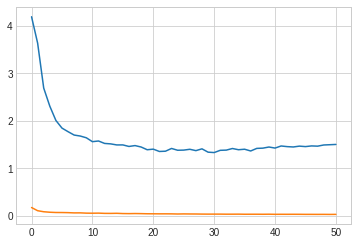

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

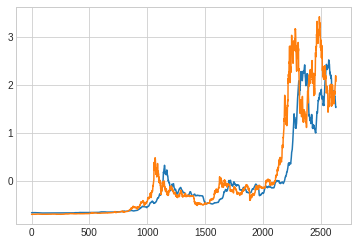

explained_variance:  0.7757
r2:  0.7604
MAE:  0.2515
MSE:  0.245
RMSE:  0.495


In [ ]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

y_pred = model.predict(X_train)
plt.plot(y_pred)
plt.plot(y_train)
plt.show()
regression_results(  y_train,y_pred)

# 6. Make future predictions

In [ ]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()
'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())


In [ ]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])


In [ ]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=[predict_value]).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=[predict_value]).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.tail()

,Close
2022-03-27,37924.394531
2022-03-28,37237.539062
2022-03-29,36807.058594
2022-03-30,36849.101562
2022-03-31,36612.234375


In [ ]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)


dataset_train.set_index( pd.date_range(start=n_starting_date, periods=2748) , inplace=True)
dataset_train.tail()
 

,Close,Open,High,Low,Volume,mov.Avg Open,mov.Avg High,mov.Avg Volume,mov.Avg Close
2022-03-22,46820.492188,44505.355469,46827.546875,44437.292969,2.816089e+10,46589.338281,47620.769531,3.171629e+10,46803.113281
2022-03-23,47128.003906,46821.851562,48086.835938,46690.203125,3.636218e+10,47110.333984,47819.075195,3.260514e+10,46798.768555
2022-03-24,47465.730469,47100.437500,48022.289062,47100.437500,3.139706e+10,47206.494792,47729.821615,3.135279e+10,46689.023438
2022-03-25,47062.664062,47456.898438,47655.148438,46746.210938,2.933388e+10,47259.523438,47583.587891,3.133066e+10,46300.669922
2022-03-26,45538.675781,47062.148438,47512.027344,45390.539062,3.332743e+10,47062.148438,47512.027344,3.332743e+10,45538.675781


In [ ]:
 PREDICTIONS_FUTURE.tail()

,Close
2022-06-14,37924.394531
2022-06-15,37237.539062
2022-06-16,36807.058594
2022-06-17,36849.101562
2022-06-18,36612.234375


# 7. Visualzie Predictions

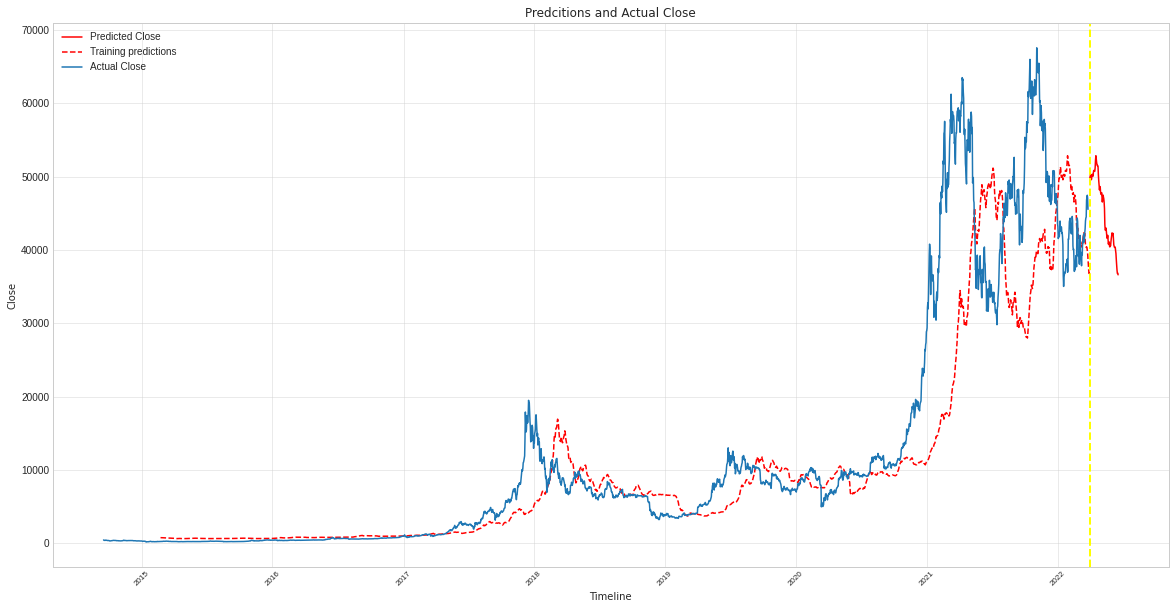

In [ ]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

plt.figure(figsize=(20, 10))


# Plot parameters
START_DATE_FOR_PLOTTING = n_starting_date
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE[predict_value], color='red', label='Predicted '+predict_value)
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:][predict_value], color='red', label='Training predictions',linestyle='dashed')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:][predict_value], label='Actual '+predict_value)

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='yellow', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Actual '+predict_value , family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel(predict_value, family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show();


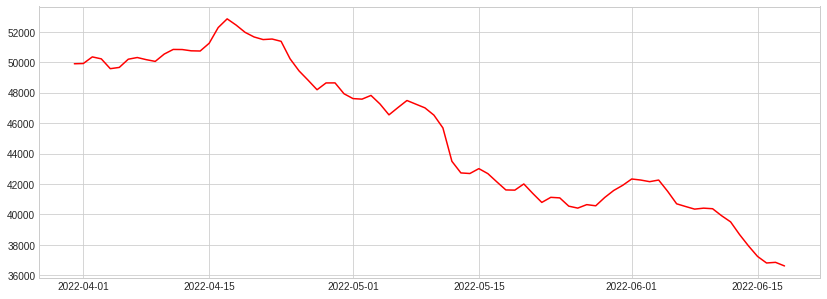

In [ ]:
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE[predict_value], color='r', label='Predicted '+predict_value)
plt.show()

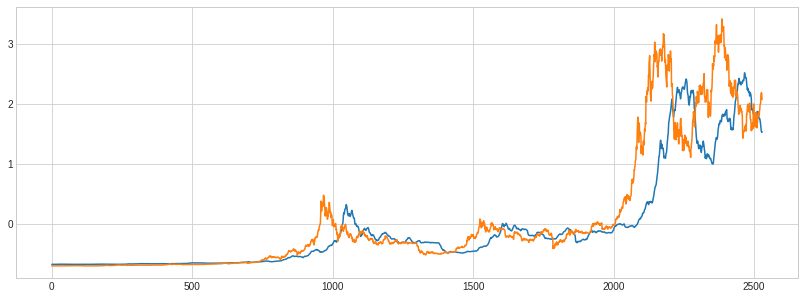

In [ ]:
year_preds =  model.predict(X_train[100:])
plt.plot(year_preds) 
plt.plot(y_train[100:]) 